# GloVe
Finetuning the GloVe embedding originally trained on the large abstract data using the 

# Imports and Setup

Common imports and standardized code for importing the relevant data, models, etc., in order to minimize copy-paste/typo errors.

Imports and colab setup

In [ ]:
%%capture import_capture --no-stder
# Jupyter magic methods
# For auto-reloading when external modules are changed
%load_ext autoreload
%autoreload 2
# For showing plots inline
%matplotlib inline

# pip installs needed in Colab for arxiv_vixra_models
!pip install wandb
!pip install pytorch-lightning
!pip install unidecode
# Update sklearn
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option(u'float_format', '{:f}'.format)
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import seaborn as sns
import torch
import wandb


`wandb` log in:

In [ ]:
wandb.login()

wandb: Currently logged in as: garrett361 (use `wandb login --relogin` to force relogin)


True

Google drive access

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing modules stored in FOLDERNAME or a subdirectory thereof:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


In [ ]:
import arxiv_vixra_models as avm

In [ ]:
notebook_model = avm.LitGloVe

Copy data to cwd for speed.

In [ ]:
SUBDIR = '/data/data_splits/'
title_tokens_file_name = 'balanced_title_normalized_vocab.feather'
!cp '{FOLDERNAME + SUBDIR + title_tokens_file_name}' .
title_tokens_df = pd.read_feather(title_tokens_file_name)
with open(FOLDERNAME + SUBDIR + 'heatmap_words.txt', 'r') as f:
    heatmap_words = f.read().split()
with open(FOLDERNAME + SUBDIR + 'pca_words.txt', 'r') as f:
    pca_words =f.read().split()
with open(FOLDERNAME + SUBDIR + 'tsne_words.txt', 'r') as f:
    tsne_words = f.read().split()

Computing specs. Save the number of processors to pass as `num_workers` into the Datamodule and cuda availability for other flags.

In [ ]:
# GPU. Save availability to IS_CUDA_AVAILABLE.
gpu_info= !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  IS_CUDA_AVAILABLE = False
else:
  print(f"GPU\n{50 * '-'}\n", gpu_info, '\n')
  IS_CUDA_AVAILABLE = True

# Memory.
from psutil import virtual_memory, cpu_count
ram_gb = virtual_memory().total / 1e9
print(f"Memory\n{50 * '-'}\n", 'Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb), '\n')

# CPU.
print(f"CPU\n{50 * '-'}\n", f'CPU Processors: {cpu_count()}')
# Determine the number of workers to use in the datamodule
NUM_PROCESSORS = cpu_count()

GPU
--------------------------------------------------
 Thu Jan 13 03:56:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                

In [ ]:
from requests import get
PROJECT = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
PROJECT = PROJECT.replace('.ipynb', '').replace('Kopie%20van%20', '').replace('Copy%20of%20', '')
print(PROJECT)
ENTITY = 'garrett361'

large_abstract_glove_finetuning


Create the mapping from words to indices and vice-versa, recalling that 0 and 1 are reserved for padding and `<UNK>`, respectively.

In [ ]:
title_word_to_idx = dict(zip(title_tokens_df.word.values, np.arange(2, len(title_tokens_df) + 2)))
title_word_to_idx['<PAD>'] = 0
title_word_to_idx['<UNK>'] = 1
title_idx_to_word = {val: key for key, val in title_word_to_idx.items()}

Load in the relevant co-occurence matrix:

In [ ]:
co_matrix = torch.load(FOLDERNAME + SUBDIR + "balanced_title_co_matrix_context_2.pt")

# Importing Best Large Abstract Glove Model

Load in the best-performing GloVe model which was trained on the large abstract data set.

In [ ]:
GLOVE_LARGE_ABSTRACT_PROJECT = 'large_abstract_glove'
wandb_api = wandb.Api()
large_abstract_glove_runs = wandb_api.runs(ENTITY + "/" + GLOVE_LARGE_ABSTRACT_PROJECT) 

run_cats = ('best_loss','config', 'name', 'wandb_path')
large_abstract_glove_runs_dict = {key: [] for key in run_cats}

for run in large_abstract_glove_runs:
    run_json = run.summary._json_dict
    if 'best_loss' in run_json:
        large_abstract_glove_runs_dict['best_loss'].append(run_json['best_loss'])
        large_abstract_glove_runs_dict['config'].append({key: val for key, val in run.config.items()})
        large_abstract_glove_runs_dict['name'].append(run.name)
        large_abstract_glove_runs_dict['wandb_path'].append('/'.join(run.path))
    
large_abstract_glove_runs_df = pd.DataFrame(large_abstract_glove_runs_dict).sort_values(by='best_loss', ascending=True).reset_index(drop=True)
large_abstract_glove_runs_df.head()

,best_loss,config,name,wandb_path
0,0.024557,"{'lr': 0.1, 'alpha': 0.75, 'x_max': 100, 'batc...",lr_0.1_scheduler_plateau,garrett361/large_abstract_glove/1pzvqhun
1,0.024748,"{'lr': 0.1, 'alpha': 0.75, 'x_max': 100, 'batc...",lr_0.1_scheduler_plateau,garrett361/large_abstract_glove/3ify2tmz
2,0.025020,"{'lr': 0.1, 'alpha': 0.75, 'x_max': 100, 'batc...",lr_0.1_scheduler_plateau,garrett361/large_abstract_glove/2ltjoose
3,0.025737,"{'alpha': 0.75, 'x_max': 100, 'pin_memory': Tr...",lr_0.1_scheduler_plateau,garrett361/large_abstract_glove/1l52vw5e
4,0.026800,"{'lr': 0.2, 'alpha': 0.75, 'x_max': 100, 'batc...",lr_0.2_scheduler_plateau,garrett361/large_abstract_glove/17f31pap


In [ ]:
best_large_abstract_glove_df = large_abstract_glove_runs_df.iloc[large_abstract_glove_runs_df['best_loss'].argmin()]
print(best_large_abstract_glove_df)

best_loss                                              0.024557
config        {'lr': 0.1, 'alpha': 0.75, 'x_max': 100, 'batc...
name                                   lr_0.1_scheduler_plateau
wandb_path             garrett361/large_abstract_glove/1pzvqhun
Name: 0, dtype: object


Save the state dicts locally and rebuild the corresponding models.

In [ ]:
large_abstract_glove_runs_df

,best_loss,config,name,wandb_path
0,0.024557,"{'lr': 0.1, 'alpha': 0.75, 'x_max': 100, 'batc...",lr_0.1_scheduler_plateau,garrett361/large_abstract_glove/1pzvqhun
1,0.024748,"{'lr': 0.1, 'alpha': 0.75, 'x_max': 100, 'batc...",lr_0.1_scheduler_plateau,garrett361/large_abstract_glove/3ify2tmz
2,0.025020,"{'lr': 0.1, 'alpha': 0.75, 'x_max': 100, 'batc...",lr_0.1_scheduler_plateau,garrett361/large_abstract_glove/2ltjoose
3,0.025737,"{'alpha': 0.75, 'x_max': 100, 'pin_memory': Tr...",lr_0.1_scheduler_plateau,garrett361/large_abstract_glove/1l52vw5e
4,0.026800,"{'lr': 0.2, 'alpha': 0.75, 'x_max': 100, 'batc...",lr_0.2_scheduler_plateau,garrett361/large_abstract_glove/17f31pap
5,0.029124,"{'alpha': 0.75, 'x_max': 100, 'pin_memory': Tr...",lr_0.05_scheduler_cyclic,garrett361/large_abstract_glove/3etujcs3
6,0.029477,"{'lr': 0.05, 'alpha': 0.75, 'x_max': 100, 'bat...",lr_0.05_scheduler_cyclic,garrett361/large_abstract_glove/1hp7w94m
7,0.029739,"{'alpha': 0.75, 'x_max': 100, 'pin_memory': Tr...",lr_0.05_scheduler_plateau,garrett361/large_abstract_glove/26a5es4c
8,0.045678,"{'alpha': 0.75, 'x_max': 100, 'pin_memory': Tr...",lr_0.05_scheduler_cyclic,garrett361/large_abstract_glove/jby4ubtc
9,0.060547,"{'alpha': 0.75, 'x_max': 100, 'pin_memory': Tr...",lr_0.05_scheduler_cyclic,garrett361/large_abstract_glove/2xfvnbli


In [ ]:
# wandb stores None values in the config dict as a string literal. Need to
# fix these entries, annoyingly.
for key, val in best_large_abstract_glove_df.config.items():
    if val == 'None':
        best_large_abstract_glove_df.config[key] = None
# Write to disk
glove_file_name = f"glove_dim_{best_large_abstract_glove_df.config['embedding_dim']}.pt"
wandb.restore(glove_file_name,
              run_path=best_large_abstract_glove_df.wandb_path,
              replace=True)
glove_file_name_suffix = '_'.join(glove_file_name.split('_')[-2:])
# Also copy to the final_models folder
!cp '{glove_file_name}' "{FOLDERNAME + '/final_models/' + PROJECT + '_' + glove_file_name_suffix}"

`wandb` also corrupts the `lr_scheduler_args` dictionary, which we fix below:

In [ ]:
best_large_abstract_glove_lr_scheduler_args = {}
for key, val in deepcopy(best_large_abstract_glove_df.config).items():
    split_key = key.split('/')
    if len(split_key) == 2 and split_key[0] == 'lr_scheduler_args':
        best_large_abstract_glove_lr_scheduler_args[split_key[-1]] = val
        del best_large_abstract_glove_df.config[key]
best_large_abstract_glove_df.config['lr_scheduler_args'] = best_large_abstract_glove_lr_scheduler_args

In [ ]:
# Inspect.
best_large_abstract_glove_df.config

{'alpha': 0.75,
 'batch_size': 1048576,
 'embedding_dim': 256,
 'lr': 0.1,
 'lr_scheduler': 'plateau',
 'lr_scheduler_args': {'factor': 0.6, 'patience': 3, 'verbose': True},
 'num_workers': 8,
 'persistent_workers': True,
 'pin_memory': True,
 'save_models_to_wandb': True,
 'x_max': 100}

In [ ]:
# Need to restore co_matrix which was not synced with wandb.
best_loss_model_args = {**deepcopy(best_large_abstract_glove_df.config), **{'co_matrix': co_matrix}}
best_loss_model = notebook_model(**best_loss_model_args)
best_loss_model.load_state_dict(torch.load(glove_file_name))

<All keys matched successfully>

# Model Training

Load in the pretrained GloVe weights to a new model and fine-tune.

In [ ]:
best_loss_model_args['pretrained_word_embedding'] = best_loss_model.word_embedding.weight.data
best_loss_model_args['pretrained_context_embedding'] = best_loss_model.context_embedding.weight.data
best_loss_model_args['pretrained_word_bias'] = best_loss_model.word_bias.data
best_loss_model_args['pretrained_context_bias'] = best_loss_model.context_bias.data

Perform a small lr test

In [ ]:
small_model = notebook_model(**{**best_loss_model_args, **{'batch_size': 2 ** 10, 
                                                           'save_models_to_wandb': False}})
small_trainer = Trainer(gpus=-1 if IS_CUDA_AVAILABLE else 0,
                        max_epochs=1,
                        )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/lr_find_temp_model_a600afd8-2bc8-4c56-8fa7-3b4e721b81d0.ckpt


Suggested lr: 0.11805470596535689


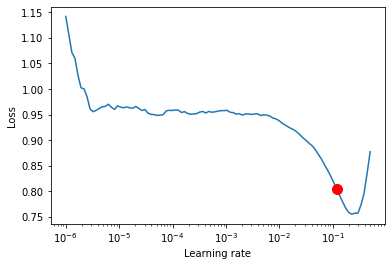

In [ ]:
small_trainer_lr_finder = small_trainer.tuner.lr_find(small_model, min_lr=1e-6, max_lr=5e-1)
small_trainer_lr_finder_plot = small_trainer_lr_finder.plot(suggest=True)
small_trainer_suggested_lr = small_trainer_lr_finder.suggestion()
print(f'Suggested lr: {small_trainer_suggested_lr}')

In [ ]:
best_loss_model_args['lr'] = small_trainer_suggested_lr
model = notebook_model(**best_loss_model_args)

Training:

In [ ]:
trainer = Trainer(logger=WandbLogger(),
                  gpus=-1 if IS_CUDA_AVAILABLE else 0,
                  log_every_n_steps=1,
                  callbacks=[avm.WandbVisualEmbeddingCallback(model=model,
                                                        heatmap_words=heatmap_words,
                                                        pca_words=pca_words,
                                                        tsne_words=tsne_words,
                                                        word_to_idx=title_word_to_idx,
                                                        idx_to_word=title_idx_to_word,
                                                        k=5,
                                                        heatmap_title=f'{PROJECT} Cosine Heatmap',
                                                        pca_title=f'{PROJECT} PCA',
                                                        tsne_title=f'{PROJECT} t-SNE',
                                                        )
                                                    ])
with wandb.init(project=PROJECT) as run:
    run.name = f"lr_{model.hparams['lr']}"
    trainer.fit(model)
    plt.close("all")


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


  | Name              | Type      | Params
------------------------------------------------
0 | word_embedding    | Embedding | 6.1 M 
1 | context_embedding | Embedding | 6.1 M 
------------------------------------------------
12.3 M    Trainable params
0         Non-trainable params
12.3 M    Total params
49.237    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Saved at global step: 1
Epoch: 0
Loss: 0.9590767621994019


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 2
Epoch: 1
Loss: 0.5658459663391113


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 3
Epoch: 2
Loss: 0.2398826628923416


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 4
Epoch: 3
Loss: 0.17196053266525269


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 6
Epoch: 5
Loss: 0.08315739035606384


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 9
Epoch: 8
Loss: 0.059859078377485275


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 12
Epoch: 11
Loss: 0.04976816847920418


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 13
Epoch: 12
Loss: 0.047117218375205994


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 15
Epoch: 14
Loss: 0.04176695644855499


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 16
Epoch: 15
Loss: 0.03623610734939575


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 17
Epoch: 16
Loss: 0.036121103912591934


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 18
Epoch: 17
Loss: 0.031021330505609512


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 19
Epoch: 18
Loss: 0.02466629445552826


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 20
Epoch: 19
Loss: 0.02281336486339569


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 22
Epoch: 21
Loss: 0.02183344028890133


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 23
Epoch: 22
Loss: 0.018304722383618355


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 24
Epoch: 23
Loss: 0.015682034194469452


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 25
Epoch: 24
Loss: 0.014971859753131866


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 26
Epoch: 25
Loss: 0.014049435034394264


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 27
Epoch: 26
Loss: 0.012441187165677547


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 28
Epoch: 27
Loss: 0.011179439723491669


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 29
Epoch: 28
Loss: 0.010480744764208794


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 30
Epoch: 29
Loss: 0.009903221391141415


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 31
Epoch: 30
Loss: 0.009009244851768017


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 32
Epoch: 31
Loss: 0.007974273525178432


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 33
Epoch: 32
Loss: 0.007267885375767946


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 34
Epoch: 33
Loss: 0.006807032972574234


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 35
Epoch: 34
Loss: 0.006327718961983919


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 36
Epoch: 35
Loss: 0.005810865666717291


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 37
Epoch: 36
Loss: 0.005293012596666813


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 38
Epoch: 37
Loss: 0.004879604559391737


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 39
Epoch: 38
Loss: 0.004575615748763084


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 40
Epoch: 39
Loss: 0.004221901297569275


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 41
Epoch: 40
Loss: 0.003848766442388296


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 42
Epoch: 41
Loss: 0.003571546170860529


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 43
Epoch: 42
Loss: 0.0033416959922760725


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 44
Epoch: 43
Loss: 0.003102554241195321


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 45
Epoch: 44
Loss: 0.002854909049347043


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 46
Epoch: 45
Loss: 0.0026355558075010777


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 47
Epoch: 46
Loss: 0.002483380725607276


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Saved at global step: 48
Epoch: 47
Loss: 0.002330714138224721


/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...



best_loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▅▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
best_loss,0.00233
epoch,47
global_step,48
train_loss,0.00233
trainer/global_step,47


# Loading Best Models

In [ ]:
wandb_api = wandb.Api()
notebook_runs = wandb_api.runs(ENTITY + "/" + PROJECT) 

run_cats = ('best_loss','config', 'name', 'wandb_path')
notebook_runs_dict = {key: [] for key in run_cats}

for run in notebook_runs:
    run_json = run.summary._json_dict
    if 'best_loss' in run_json:
        notebook_runs_dict['best_loss'].append(run_json['best_loss'])
        notebook_runs_dict['config'].append({key: val for key, val in run.config.items()})
        notebook_runs_dict['name'].append(run.name)
        notebook_runs_dict['wandb_path'].append('/'.join(run.path))
    
notebook_runs_df = pd.DataFrame(notebook_runs_dict).sort_values(by='best_loss', ascending=True).reset_index(drop=True)
notebook_runs_df.head()

,best_loss,config,name,wandb_path
0,0.002331,"{'lr': 0.11805470596535687, 'alpha': 0.75, 'x_...",lr_0.11805470596535689,garrett361/large_abstract_glove_finetuning/3o8...


In [ ]:
best_loss_model_df = notebook_runs_df.iloc[notebook_runs_df['best_loss'].argmin()]
print(best_loss_model_df)

best_loss                                              0.002331
config        {'lr': 0.11805470596535687, 'alpha': 0.75, 'x_...
name                                     lr_0.11805470596535689
wandb_path    garrett361/large_abstract_glove_finetuning/3o8...
Name: 0, dtype: object


Save the state dicts locally and rebuild the corresponding models.

In [ ]:
best_loss_model_path = best_loss_model_df.wandb_path
# wandb stores None values in the config dict as a string literal. Need to
# fix these entries, annoyingly.
for key, val in best_loss_model_df.config.items():
    if val == 'None':
        best_loss_model_df.config[key] = None
# Write to disk
glove_file_name = f"glove_dim_{best_loss_model_df.config['embedding_dim']}.pt"
wandb.restore(glove_file_name,
              run_path=best_loss_model_df.wandb_path,
              replace=True)
glove_file_name_suffix = '_'.join(glove_file_name.split('_')[-2:])
# Also copy to the final_models folder
!cp '{glove_file_name}' "{FOLDERNAME + '/final_models/' + PROJECT + '_' + glove_file_name_suffix}"

In [ ]:
cyclic_lr_scheduler_args = {'base_lr': 5e-9,
                            'max_lr': 5e-7,
                            'step_size_up': 100,
                            'cycle_momentum': False}

In [ ]:
best_loss_model = notebook_model(**{**best_loss_model_df.config, **{'co_matrix': co_matrix}})
best_loss_model.load_state_dict(torch.load(glove_file_name))

<All keys matched successfully>

# Visualize

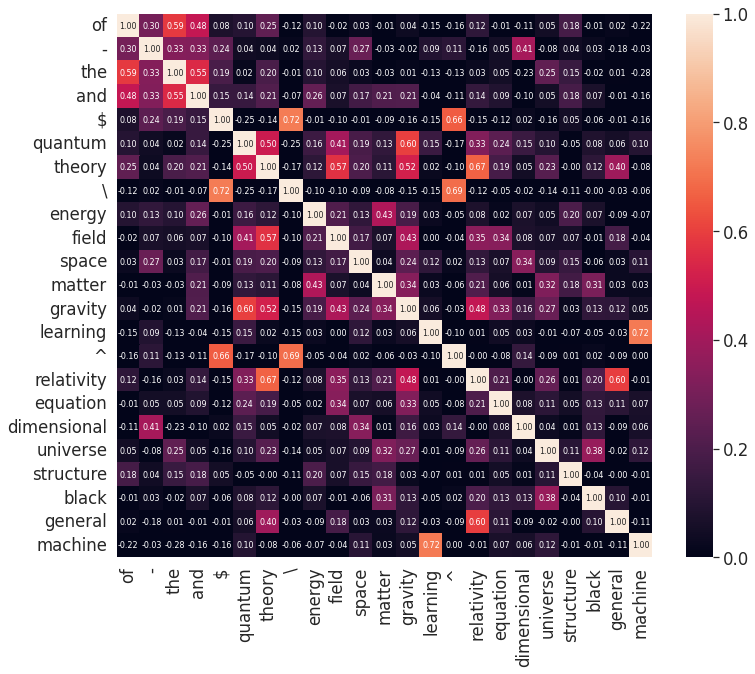

In [ ]:
heatmap = avm.embedding_cosine_heatmap(model=best_loss_model,
                                       words=heatmap_words,
                                       word_to_idx=title_word_to_idx)

In [ ]:
pca = avm.pca_3d_embedding_plotter_topk(model=best_loss_model,
                                     words=pca_words,
                                     word_to_idx=title_word_to_idx,
                                     idx_to_word=title_idx_to_word,
                                     title='PCA',
                                     k=5)

In [ ]:
tsne = avm.tsne_3d_embedding_plotter_topk(model=best_loss_model,
                                     words=tsne_words,
                                     word_to_idx=title_word_to_idx,
                                     idx_to_word=title_idx_to_word,
                                     title='t-SNE',
                                     k=5)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



In [ ]:
pca.show()

In [ ]:
tsne.show()

In [ ]:
avm.embedding_utils.topk_analogies_df(best_loss_model,
                                      'newton mechanics heisenberg'.split(),
                                      title_word_to_idx,
                                      title_idx_to_word)

,word0,word1,word2,word3,word3_idx,cos
0,newton,mechanics,heisenberg,quantum,15,0.46231845
1,newton,mechanics,heisenberg,classical,147,0.36135328
2,newton,mechanics,heisenberg,contact,961,0.3502479
3,newton,mechanics,heisenberg,sir,5901,0.34125185
4,newton,mechanics,heisenberg,fermionic,1667,0.33316305
